Ce carnet traitera de manipulations géographiques assez basiques, **pour se familiariser avec le module geopandas**. Le principal objectif est d'automatiser un travail précédent, <a href="https://www.rue89strasbourg.com/deux-balades-pour-decouvrir-le-patrimoine-excentre-de-strasbourg-65236" target="_blank">centré sur le patrimoine excentré de Strasbourg</a>.

![Le patrimoine excentré de Strasbourg (Rue89 Strasbourg)](illustrations/patex_strasbourg.png)

Il s'agissait d'une cartographie de quelques monuments historiques de la ville, reliés par deux circuits (vélo et bus/tram). J'ai essayé de reproduire la recette en Python, notamment **pour éprouver son automatisation**.

Pour cela, on partira d'un csv créé <a href="https://github.com/raphadasilva/blog_rdasilva/blob/master/autodonnees/webscraping/scraper_du_html_en_python.ipynb" target="_blakn">en aspirant des données de Wikipedia</a> afin de :
 - **faire des sélections** sur un ensemble de points
 - **trier l'échantillon réduit** en différentes étapes d'un circuit
 - **calculer le trajet associé**
 - enregistrer ce qui doit l'être **au format geojson**
 
Voici les modules retenus :

In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
%matplotlib inline 
# la ligne précédente sert à afficher correctement une image dans un notebook ipython ou Jupyter

import pandas as pd
import geopandas as gp
import numpy as np
import networkx as nx
import mlrose
import matplotlib.pyplot as plt
import osmnx as ox
from shapely.geometry import Point

## Sélectionner le patrimoine excentré de Nancy

La première étape va consister à isoler le patrimoine excentré de Nancy. Concrètement, on va considérer l'ensemble des monuments historiques de la ville, **et définir un centre**.

Solution arbitraire parmi d'autres : calculer **la moyenne des latitudes et longitudes de l'ensemble des points**. La bibliothèque pandas est toute destinée pour cela. On entame par l'affichage des premières entrées du csv comme suit :

In [2]:
fichier = pd.read_csv("data/monuments_histo_nancy.csv", sep = ",") # la variable retournée est une DataFrame
fichier.tail()

,Monument,Adresse,Longitude,Latitude,Source
259,Porte Sainte-Catherine,rue Sainte-Catherine - boulevard du 26e-RI\n,48.6956,6.1900,https://www.pop.culture.gouv.fr/notice/merimee...
260,Porte Saint-Georges,Place du Colonel-Driant - avenue du XXe-Corps-...,48.6924,6.1887,https://www.pop.culture.gouv.fr/notice/merimee...
261,Porte Saint-Nicolas,place des Vosges (Nancy) - rue Saint-Dizier\n,48.6855,6.1865,https://www.pop.culture.gouv.fr/notice/merimee...
262,Porte Stanislas,rue Stanislas - rue Mazagran\n,48.6912,6.1755,https://www.pop.culture.gouv.fr/notice/merimee...
263,Temple protestant de Nancy,place Maginot\n,48.6901,6.1778,https://www.pop.culture.gouv.fr/notice/merimee...


Maintenant que nous connaissons les noms des colonnes qui nous intéressent ("Longitude" et "Latitude"), nous pouvons calculer les moyennes correspondantes :

In [3]:
latitude_centre=fichier["Latitude"].mean()  # traduction en langage pandas : moyenne de la Série "Latitude"
longitude_centre=fichier["Longitude"].mean()

Cette formalité complétée, on peut passer à l'étape geopandas. Il faut au prélable transformer les coordonnées de la DataFrame fichier en géométrie interprétables par geopandas.

Une petite compréhension de listes avec le module shapely va règler le souci :

In [4]:
geometrie_mh_nancy = [Point(xy) for xy in zip(fichier["Longitude"], fichier["Latitude"])]
fichier_geo = gp.GeoDataFrame(fichier, crs=None, geometry=geometrie_mh_nancy)

On peut faire de même avec le centre défini avant :

In [5]:
coord_centre = [Point(longitude_centre, latitude_centre)]
centre = gp.GeoDataFrame(crs=None, geometry=coord_centre)

**La bibliothèque matplotlib** va afficher en quelques commandes les monuments historiques de Nancy, ainsi que le centre que nous avons défini juste avant :

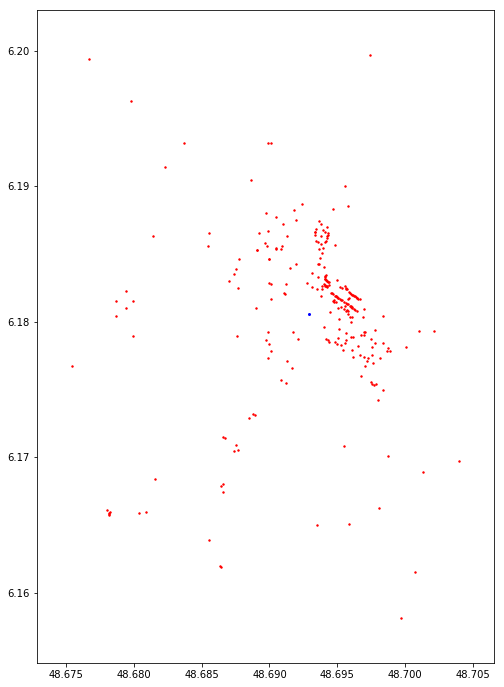

In [6]:
fig, ax = plt.subplots(figsize=(12,12))

fichier_geo.plot(ax=ax, marker='o', color='red', markersize=2)
centre.plot(ax=ax, marker='o', color='blue', markersize=4)

A partir de ce centre, on va dresser **un cercle de diamètre assez large** pour englober une bonne partie des monuments historiques.

C'est donc reparti pour un tour :

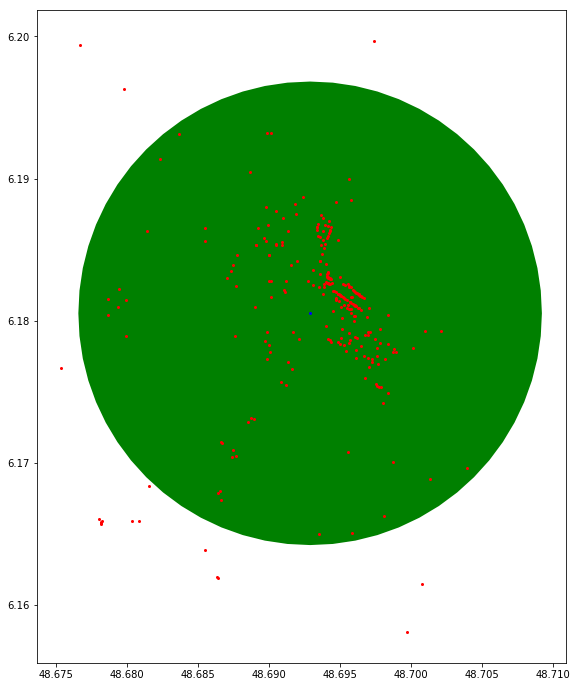

In [7]:
fig, ax = plt.subplots(figsize=(12,12)) # on doit à chaque fois reparamétrer le graphique

cercle = gp.GeoDataFrame(crs=None, geometry=centre.buffer(0.0163))
cercle.plot(ax=ax, color = 'green') # on commence par afficher le cercle car le premier calque est celui du dessous

fichier_geo.plot(ax=ax, marker='o', color='red', markersize=4)
centre.plot(ax=ax, color = 'blue',markersize=4)

Le principe de la sélection va être le suivant :
- **distinguer les points à l'intérieur** du cercle
- faire **une différence entre cette sélection et l'ensemble des points**
- **ne retenir que les points hors du cercle**

Une visualisation est parfaite pour s'assurer qu'il n'y a pas eu de souci :

Nombre de monuments : 264
Monuments centraux : 247
Patrimoine excentrée : 17


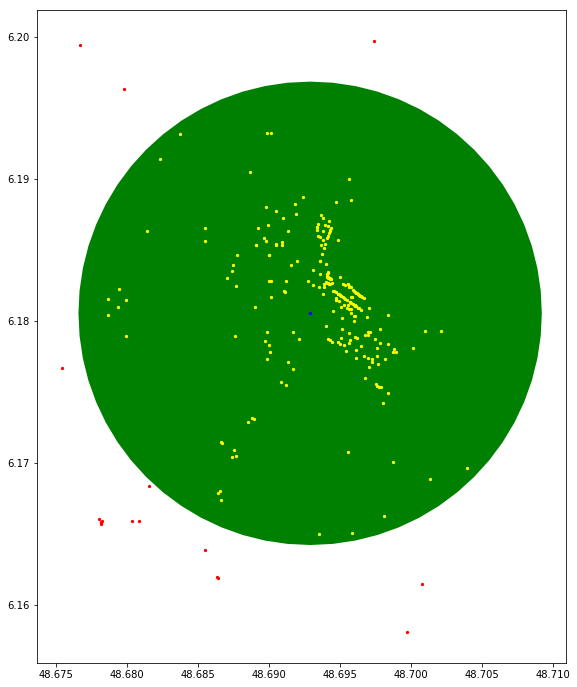

In [8]:
points_int = gp.sjoin(fichier_geo,cercle, how = "inner")
points_ext = fichier_geo[~fichier_geo.index.isin(points_int.index)] # remarquez que la soustraction se fait au niveau des index

fig, ax = plt.subplots(figsize=(12,12))
ax.set_aspect('equal')
cercle.plot(color = 'green',ax=ax)
centre.plot(ax=ax,color = 'blue', markersize=5)
points_int.plot(ax=ax,marker='o', color='yellow', markersize=5)
points_ext.plot(ax=ax,marker='o', color='red', markersize=5)

print('Nombre de monuments :' ,len(fichier_geo))
print('Monuments centraux :' ,len(points_int))
print('Patrimoine excentrée :' ,len(points_ext))

La DataFrame points_ext correspond aux 17 points rouges de la visualisation précédente. Mais, il faut un peu la retravailler :

In [9]:
points_ext.head()

,Monument,Adresse,Longitude,Latitude,Source,geometry
9,Croix-Gagnee,Rue de la Croix-Gagnée\n,48.699708,6.158089,https://www.pop.culture.gouv.fr/notice/merimee...,POINT (48.699708 6.158089)
10,Eglise Notre-Dame-Bonsecours,254 avenue de Strasbourg\n,48.676700,6.199400,https://www.pop.culture.gouv.fr/notice/merimee...,POINT (48.6767 6.1994)
28,Maison Jeune,30 rue du Sergent-Blandan\n,48.680871,6.165926,https://www.pop.culture.gouv.fr/notice/merimee...,POINT (48.680871 6.165926)
29,Parc Corbin,36 rue du Sergent-Blandan\n,48.680339,6.165897,https://www.pop.culture.gouv.fr/notice/merimee...,POINT (48.680339 6.165897)
102,Maison,24 rue Félix-Faure\n,48.678219,6.165940,https://www.pop.culture.gouv.fr/notice/merimee...,POINT (48.678219 6.16594)


L'index suit la DataFrame de base (fichier_geo), c'est pour ça que la première ligne de points_ext a l'index 9, la troisième l'index 28, et la cinquième l'index 102. Pour plus de lisibilité, on va remettre à 0 l'index de points_ext ainsi :

In [10]:
points_ext.reset_index(drop=True, inplace=True)

points_ext.head()

,Monument,Adresse,Longitude,Latitude,Source,geometry
0,Croix-Gagnee,Rue de la Croix-Gagnée\n,48.699708,6.158089,https://www.pop.culture.gouv.fr/notice/merimee...,POINT (48.699708 6.158089)
1,Eglise Notre-Dame-Bonsecours,254 avenue de Strasbourg\n,48.676700,6.199400,https://www.pop.culture.gouv.fr/notice/merimee...,POINT (48.6767 6.1994)
2,Maison Jeune,30 rue du Sergent-Blandan\n,48.680871,6.165926,https://www.pop.culture.gouv.fr/notice/merimee...,POINT (48.680871 6.165926)
3,Parc Corbin,36 rue du Sergent-Blandan\n,48.680339,6.165897,https://www.pop.culture.gouv.fr/notice/merimee...,POINT (48.680339 6.165897)
4,Maison,24 rue Félix-Faure\n,48.678219,6.165940,https://www.pop.culture.gouv.fr/notice/merimee...,POINT (48.678219 6.16594)


Tout est propre, on désormais peut transformer cette GeoDataFrame en csv (en supprimant la colonne geometry qui est devenue superflue) :

In [11]:
points_ext[["Monument", "Adresse","Longitude","Latitude","Source"]].to_csv('data/a_trier.csv', sep=",",index=False)

## Le circuit et son tri

L'ordre des monuments de notre dernière fichier **n'est pas lié à leur géographie**. Il va donc falloir trier ces éléments **en étapes d'un circuit le plus court possible**. Ce défi d'optimisation bien connu s'appelle couramment <a href="https://hal.archives-ouvertes.fr/hal-00152332/document" target="_blank">le problème du voyageur de commerce</a>.

Pour l'illustrer, avec 17 étapes constituant un patrimoine excentré de Nancy, on a **plus de 10 461 milliards de chemins différents**. Tomber par hasard sur le bon circuit tiendrait du miracle, comparer l'ensemble des parcours relèverait de l'éternité.

Heureusement, **certains algorithmes d'apprentissage automatique** peuvent nous prêter main forte. Nous allons utiliser certaines fonctions <a href="https://mlrose.readthedocs.io/en/stable/" target="_blank">du module Python mlrose</a>, développé par la data scientist <a href="http://www.genevievehayes.com/" target="_blank"> Genevieve Hayes</a>.

On va reprendre le tutoriel qui <a href="https://mlrose.readthedocs.io/en/stable/source/tutorial2.html" target="_blank">résout le problème du voyageur du commerce pour huit étapes</a>, et réadapter les différents paramètres à notre sauce :

In [12]:
a_trier = pd.read_csv("data/a_trier.csv", sep = ",")

liste_points = [(x,y) for x,y in zip(a_trier["Longitude"], a_trier["Latitude"])]

coord_entrainement = mlrose.TravellingSales(coords = liste_points)

param_entrainement = mlrose.TSPOpt(length = 17, fitness_fn = coord_entrainement, maximize=False)

meilleur_parcours, meilleure_distance = mlrose.genetic_alg(param_entrainement, mutation_prob = 1, max_attempts = 300, random_state = 3)

print(meilleur_parcours)

print(meilleure_distance)

[ 7  6 12 15  1 16  0 11  4  3 14  9 10 13  2  5  8]
0.14816884746842546


Moins de trois minutes, et l'affaire est pliée. Si on devait redéfinir a_trier avec un rangement optimal, la septième ligne devrait être en première position, la sixième en deuxième, la douzième en troisième, etc...

meilleurs_parcours étant un tableau numpy, on a juste à **le convertir en liste** pour pouvoir ensuite trier la DataFrame désordonnée en fonction de ce nouvel index.

En Python, ça se traduit ainsi :

In [13]:
ordre_tri = meilleur_parcours.tolist()

a_trier = a_trier.iloc[ordre_tri].reset_index(drop=True)

## Le circuit optimal

On peut passer à la dernière phase du job : **afficher le circuit reliant les 17 monuments**. Pour ce faire, on va avoir recours au module <a href="https://github.com/gboeing/osmnx" target="_blank">OSMnx</a>, développé par <a href="https://geoffboeing.com/" target="_blank">Geoff Boeing</a>. Il dresse des réseaux de rues à partir de données téléchargées via l'API d'OpenStreetMap.

L'une de ses fonctions va nous servir **à enregistrer le trajet le plus court entre deux points** (et plus). Mais avant, il faut regrouper les coordonnées de chaque monument, et ajouter ensuite le premier élément en fin de liste afin de fermer le circuit :

In [14]:
patex_nancy = a_trier[["Latitude", "Longitude"]].values.tolist()

patex_nancy.append(patex_nancy[0])

Il est maintenant temps d'appliquer cette recette sur les rues de Nancy :

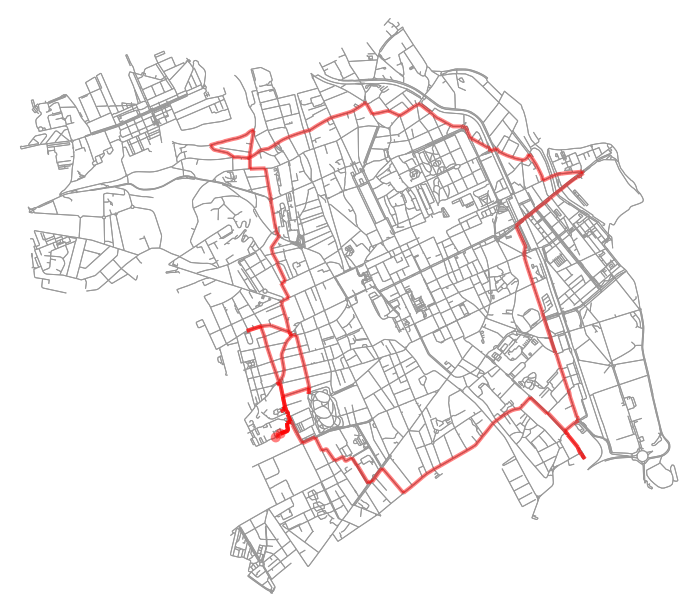

In [15]:
ox.config(log_console=True, use_cache=True) # cette ligne sert à afficher les requêtes d'OSMnx dans le terminal

G = ox.graph_from_place('Nancy, France', network_type='walk')
circuit = []

for point1, point2 in zip(patex_nancy[:-1], patex_nancy[1:]): # on considère un point et le suivant (en faisant gaffe à l'index du second)
    orig = ox.get_nearest_node(G, tuple(reversed(point1))) # on prend le noeud le plus proche du premier point...
    dest = ox.get_nearest_node(G, tuple(reversed(point2))) # ...puis le noeud le plus proche du second
    intermediate_route = nx.shortest_path(G, orig, dest, weight='length') # et on calcule le parcours le plus court entre les deux
    circuit.extend(intermediate_route[:-1]) # on ajoute ce tracé au circuit global
    
fig, ax = ox.plot_graph_route(G, circuit, fig_height=11, node_size=0)

Techniquement, la variable circuit est **une liste contenant les différents id des noeuds du parcours**. C'est embêtant, puisqu'il nous faudrait une seule et unique ligne continue. On peut heureusement transformer circuit en une GeoDataFrame comme ceci :

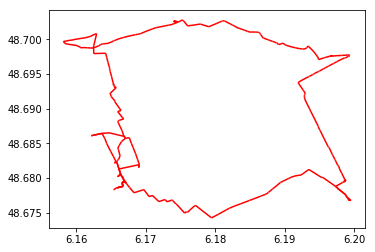

In [16]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

gdf_edges.index = gdf_edges.apply(lambda row: (row.u, row.v), axis=1)
trajet = gdf_edges.loc[list(zip(circuit[:-1], circuit[1:]))]

trajet.plot(color='red')

On a besoin du strict minimum pour ce parcours. Une solution assez élégante est de paramétrer un schéma de fichier avec les informations indispensables

In [17]:
gp_transition = gp.GeoDataFrame(trajet[['u','v','key']], 
                                geometry=trajet['geometry']) # la projection peut être évidemment changé selon les besoins

gp_transition.to_file('livraisons/circuit_patex_nancy.json', driver="GeoJSON")

Et on termine de la même façon sur points_ext (plus besoin de se soucier de l'ordre), pensant bien à inverser les coordonnées :

In [18]:
gp_transition_mh = gp.GeoDataFrame(points_ext[['Monument','Adresse','Source']], 
                                   geometry=[Point(reversed(list(point.coords)[0])) for point in points_ext["geometry"]])


gp_transition_mh.to_file('livraisons/patex_nancy.json', driver="GeoJSON")